#### Bayesian optimization

So far, we have seen what Bayesian kernel regression can do to `fit` 1D training data points and describe its prediction `mean` and `uncertainty` at those places where no data is observed (e.g., testing data points)

One useful application of this information is to do `optimization` of an underlying function that generates these training data

For example, the input of the function can be % of certain ingredient used and the output can be the effectiveness of a certain drug in reducing blood pressure, apparently, we want to maximize this underlying function

The same principle applies to many minimization scenarios in the real world

The key idea of using Bayesian kernel regression for optimization is to design a `criterion` that combines both prediction `mean` and prediction `uncertainty` at each optimization iteration, such that the `next data point` for evaluation can be determined that represents the most probable `improvement` as quantified by this criterion

We take a look at a simple criterion called `lower confidence bound` in this notebook (or `upper confidence bound` if we need maximization)

$$LCB(x)=\mu(x)-k\sigma(x)$$

* `Exploitation` term $\mu(x)$: focuses on selecting points where the `predicted mean` is low, based on model in current iteration
* `Exploration` term $-k\sigma(x)$: encourages sampling in regions with `high uncertainty` (consequently, lower LCB). Higher values of parameter $k$ result in more exploration

By using LCB, we are basically saying that
* we want to explore the regions where the model at current iteration tells us that the function is predicted to have low value (since we want to minimize the function)
* but at the same time, we also want to explore the regions with high uncertainty such that we can reduce the uncertainty in these regions quickly, and avoid missing potential minimizers hidden in these regions

Ultimately, the "best" data point $x$ to evaluate in the `next iteration` should have the `smallest LCB` among all testing data points

Then, we evaluate the output corresponding to this $x$ by fitting a new Bayesian kernel regression model to include this new data, and determine the next data point to evaluate

This whole process repeats, and we hope to `converge` to the actual minimum of the function with this `sequential` process

Perfect, now we will implement LCB to see how it goes

In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.2e}'.format})

In [2]:
class BayesianKernelRegression:
    def __init__(self, num_points=30, num_x_test=200, debug=False, random_seed=42, lcb_k=1.0):
        np.random.seed(random_seed)

        self.debug = debug # Toggle printing stuff

        # Initialize parameters as class attributes
        self.num_points = num_points # Original data points
        self.num_x_test = num_x_test # Number of x_test
        self.sigma_d_true = 0.2 # True standard deviation of noise in measured y, only used in generating data
        self.sigma_d = 0.1 # Guessed standard deviation of noise in measured y, only used in model
        self.sigma_k = 2 # Kernel
        self.sigma_theta = 0.5 # Prior of theta
        self.learning_rate = 0.00001
        self.iterations = 10000
        self.num_samples_metropolis = 300 # For Metropolis
        self.step_size = 1e-2
        self.threshold = 1e-10 # For removing small eigenvectors
        self.num_samples_predictive_per_theta = 5 # Number of samples in MC approximation of Bayesian marginalization, for each theta at each x_test

        self.lcb_k = lcb_k  # Confidence level parameter for LCB

        self.x_l = 0 # Lower end of x
        self.x_h = 6 * np.pi # Higher end of x

        # Data
        self.x = np.random.uniform(self.x_l, self.x_h, self.num_points)
        self.y = self.create_function(self.x)

        # x_test
        self.x_test = np.linspace(self.x.min()-2, self.x.max()+2, self.num_x_test)

    # Create function
    def create_function(self, x, noiseless=False):
        y = np.cos(0.4*(x-5))  # True underlying function
        if not noiseless:
            y += np.random.normal(0, self.sigma_d_true, size=x.shape)
        return y

    # Virtual samples for original x
    def generate_virtual_samples_train(self):
        self.x_k = self.rbf_kernel_vectorized(self.x.reshape(-1, 1), self.x.reshape(-1, 1))
        eigenvalues, eigenvectors = np.linalg.eigh(self.x_k)
        if self.debug:
            print(f'raw eigenvalues: {eigenvalues.shape}')
            print(f'raw eigenvectors: {eigenvectors.shape}')

        mask = eigenvalues > self.threshold
        self.eigenvalues = eigenvalues[mask]
        self.eigenvectors = eigenvectors[:, mask]
        self.v_samples_train = self.eigenvectors @ np.diag(np.sqrt(self.eigenvalues))
        if self.debug:
            print(f'eigenvalues after thresholding (if needed): {self.eigenvalues.shape}')
            print(f'eigenvectors after thresholding (if needed): {self.eigenvectors.shape}')
            print(f'x_k: {self.x_k.shape}\n{self.x_k[:5,:5]}')
            print(f'v_samples_train @ v_samples_train.T: \n{(self.v_samples_train @ self.v_samples_train.T)[:5,:5]}')
            print(f'virtual samples shape: {self.v_samples_train.shape}')
            print()

    # Virtual samples for x_test
    def generate_virtual_samples_test(self):
        self.x_k_test = self.rbf_kernel_vectorized(self.x_test.reshape(-1, 1), self.x.reshape(-1, 1))
        self.v_samples_test = self.x_k_test @ self.eigenvectors @ np.diag(1 / np.sqrt(self.eigenvalues))
        if self.debug:
            print(f'v_samples_test shape: {self.v_samples_test.shape}')
            print(f'x_k_test[-5:,-5:]: \n {self.x_k_test[-5:,-5:]}')
            print(f'(v_samples_test@v_samples_train.T)[-5:,-5:]: \n{(self.v_samples_test@self.v_samples_train.T)[-5:,-5:]}')
            print()

    # Kernel function
    def rbf_kernel_vectorized(self, x_set_1, x_set_2):
        # Number of points in each set
        num_points_1 = x_set_1.shape[0]
        num_points_2 = x_set_2.shape[0]

        # Calculate each point squared
        x1_sq_norms = np.sum(x_set_1 ** 2, axis=1).reshape(num_points_1, 1)  # Shape (num_points_1, 1)
        x2_sq_norms = np.sum(x_set_2 ** 2, axis=1).reshape(1, num_points_2)  # Shape (1, num_points_2)

        # Compute pairwise squared Euclidean distances
        sq_dists = x1_sq_norms + x2_sq_norms - 2 * np.dot(x_set_1, x_set_2.T)  # Shape (num_points_1, num_points_2)

        # Compute RBF kernel
        k_mat = np.exp(-sq_dists / (2 * self.sigma_k ** 2))

        return k_mat

    # Gradient descent, MAP or ML
    def gradient_descent(self):
        theta = np.zeros(self.v_samples_train.shape[1])
        for k in range(self.iterations):
            y_pred = self.v_samples_train @ theta
            prior_theta = np.mean(theta**2) / self.sigma_theta**2
            likelihood = np.mean((y_pred - self.y)**2) / self.sigma_d**2
            loss = prior_theta + likelihood

            grad_prior_theta = theta / self.sigma_theta**2
            grad_likelihood = self.v_samples_train.T @ (y_pred - self.y) / self.sigma_d**2
            grad_loss = grad_prior_theta + grad_likelihood
            theta -= self.learning_rate * grad_loss

            if self.debug and k % (self.iterations // 10) == 0:
                print(f"Iteration {k}: loss = {loss:.4f}")

        if self.debug:
            print(f"MAP estimate of parameters: {theta}")
            print()
        return theta

    # Compute probability to evaluate whether to accept new theta in Metroplis
    def posterior(self, theta):
        # Posterior p(theta|D) is proportional to prior p(theta) times likelihood p(D|theta)
        y_pred = self.v_samples_train @ theta
        prior = np.exp(-0.5 * np.sum(theta**2) / self.sigma_theta**2)
        likelihood = np.exp(-0.5 * np.sum((y_pred - self.y)**2) / self.sigma_d**2)
        return prior * likelihood

    # Metropolis
    def metropolis(self, theta_init):
        samples = []
        theta_current = theta_init
        accepted = 0

        # Evaluate probability of current theta
        posterior_current = self.posterior(theta_current)

        # Compute covariance matrix based on step size, to select next theta
        proposal_cov = np.eye(theta_current.shape[0]) * self.step_size

        for _ in range(self.num_samples_metropolis):
            # Get new theta using Gaussian distribution
            theta_proposal = np.random.multivariate_normal(theta_current, proposal_cov)
            # Compute probability of new theta
            posterior_proposal = self.posterior(theta_proposal)
            # Compute ratio between new and old
            acceptance_prob = posterior_proposal / posterior_current
            # Determine acceptance
            if np.random.rand() < acceptance_prob:
                accepted += 1
                theta_current = theta_proposal
                posterior_current = posterior_proposal
            # Add to sample list
            samples.append(theta_current)

        self.theta_samples = np.array(samples)
        acceptance_rate = accepted / self.num_samples_metropolis
        print(f"Metropolis acceptance rate: {acceptance_rate:.2f}")

        if self.debug:
            print(f'Metropolis samples shape: {self.theta_samples.shape}')
            print()

    # Monte Carlo integration
    def compute_posterior_numerical_vectorized(self):

        # Vectorize computation of prediction means at all v_samples_test (row) for all thetas from metropolis (col)
        y_pred_mean_mat = self.v_samples_test @ self.theta_samples.T

        num_test_points = y_pred_mean_mat.shape[0]  # Number of test points for which we are making predictions
        num_theta_samples = y_pred_mean_mat.shape[1]  # Number of theta samples from Metropolis, representing different plausible theta

        # Simultaneously generate samples from prediction distribution at all y_pred_mean_mat
        noise_samples = np.random.normal(
            loc=0,
            scale=self.sigma_d,
            size=(num_test_points, num_theta_samples, self.num_samples_predictive_per_theta)
        )

        # Reshape y_pred_mean_mat to match noise_samples for broadcasting
        y_pred_mean_mat_reshaped = y_pred_mean_mat.reshape(num_test_points, num_theta_samples, 1)

        # Broadcast
        predictive_samples = y_pred_mean_mat_reshaped + noise_samples

        # Reshape to aggregate, for each x_test, all samples corresponding to prediction distributions based on all thetas
        merged_predictive_samples = predictive_samples.reshape(num_test_points, -1)

        # Compute mean and variance over all aggregated samples for each test point
        posterior_mean_y = np.mean(merged_predictive_samples, axis=1)
        posterior_var_y = np.var(merged_predictive_samples, axis=1)

        # Calculate diagonal elements of kernel matrix for variance correction
        self.k_star_star_diag = np.ones(self.x_test.shape[0])  # Diagonal elements are 1 for RBF kernel

        # Compute diagonal of v_samples_test @ v_samples_test.T
        v_samples_diag = np.sum(self.v_samples_test**2, axis=1)

        # Correction step
        posterior_var_y_corrected = posterior_var_y - v_samples_diag + self.k_star_star_diag

        # Take square root to obtain standard deviation
        posterior_std_y = np.sqrt(posterior_var_y_corrected)

        return posterior_mean_y, posterior_std_y

    # Analytical solution (as reference to check our numerical results)
    def analytical_solution(self, use_formula='2.12'):
        if use_formula == '2.12':
            # Compute posterior mean and covariance using kernel in original space, per eq. 2.12, in Rasmussen and Williams's Gaussian process book

            H_mat = self.x_k + np.eye(self.x_k.shape[0]) * self.sigma_d**2
            H_mat = (H_mat + H_mat.T) / 2  # Ensure symmetry
            H_mat += np.eye(H_mat.shape[0]) * 1e-6  # Numerical stability
            H_mat_inv = np.linalg.inv(H_mat)

            analytical_mean_y = self.x_k_test @ H_mat_inv @ self.y

            # Compute diagonal elements of x_k_test @ H_mat_inv @ x_k_test.T
            temp = self.x_k_test @ H_mat_inv  # Shape: (num_test, num_train)
            x_k_test_diag_product = np.sum(temp * self.x_k_test, axis=1)

            # Compute diagonal of covariance matrix
            cov_diag = self.k_star_star_diag - x_k_test_diag_product

            # Compute standard deviation
            analytical_std_y = np.sqrt(cov_diag)

            return analytical_mean_y, analytical_std_y

        elif use_formula == '2.11':
            # Compute covariance using virtual sample in feature space, eq. 2.11
            A_mat = self.v_samples_train.T @ self.v_samples_train / self.sigma_d**2 + np.eye(self.v_samples_train.shape[1]) / self.sigma_theta**2

            A_mat = (A_mat + A_mat.T) / 2  # Ensure symmetry
            A_mat += np.eye(A_mat.shape[0]) * 1e-6  # Numerical stability
            A_mat_inv = np.linalg.inv(A_mat)

            mean_2 = 1 / self.sigma_d**2 * self.v_samples_test @ A_mat_inv @ self.v_samples_train.T @ self.y
            analytical_mean_y = mean_2

            # Compute diagonal elements of v_samples_test @ A_mat_inv @ v_samples_test.T
            temp = self.v_samples_test @ A_mat_inv  # Shape: (num_test, num_features)
            cov_diag_feature = np.sum(temp * self.v_samples_test, axis=1)

            # Compute diagonal elements of v_samples_test @ v_samples_test.T
            v_samples_diag = np.sum(self.v_samples_test**2, axis=1)

            # Correct posterior variance
            cov_diag = cov_diag_feature - v_samples_diag + self.k_star_star_diag

            # Compute standard deviation
            analytical_std_y = np.sqrt(cov_diag)

            return analytical_mean_y, analytical_std_y

    """Compute lower confidence bound"""
    def lower_confidence_bound(self, mean, std):
        # Calculate LCB for minimization
        return mean - self.lcb_k * std

    # Compute next best x using LCB for Bayesian optimization
    def compute_next_best_x_lcb_vectorized(self):
        # Compute LCB for all test points at once
        lcbs = self.lower_confidence_bound(self.posterior_mean_numerical, self.posterior_std_numerical)

        # Determine x_test with lowest LCB value
        next_best_x_index = np.argmin(lcbs)  # Get index of next best x
        next_best_x = self.x_test[next_best_x_index]  # Pull x value corresponding to that index

        return next_best_x

    # Plot stuff
    def plot_results(self, next_best_point=None, iteration=None):
        fig, axes = plt.subplots(1, 3, figsize=(17, 4.5))

        # Check if there is a new point to add
        if next_best_point is not None:
            next_best_x, new_y = next_best_point

        # Metropolis samples
        axes[0].scatter(self.x, self.y, color='yellow', label='Data points', alpha=0.9, edgecolors='w', zorder=10)
        for i in range(self.num_samples_metropolis):
            axes[0].plot(self.x_test, self.y_test_samples.T[i], color='magenta', alpha=0.1)

        # Plot curve corresponding to theta_MAP or theta_ML
        y_map = self.v_samples_test @ self.theta_map
        axes[0].plot(self.x_test, y_map, color='white', linestyle='-', label='MAP/ML estimate')

        axes[0].set_title('Metropolis sampling from p(theta|D)')
        axes[0].grid(True, alpha=0.2)

        # Plot numerical solution
        axes[1].scatter(self.x, self.y, label='Data', color='yellow')
        axes[1].plot(self.x_test, self.create_function(self.x_test, noiseless=True), label='True function', color='orange', linestyle='--')
        axes[1].plot(self.x_test, self.posterior_mean_numerical, label='Numerical mean', color='cyan')
        axes[1].fill_between(self.x_test, self.posterior_mean_numerical - 2 * self.posterior_std_numerical,
                            self.posterior_mean_numerical + 2 * self.posterior_std_numerical, color='cyan', alpha=0.3)

        # Plot next best x and corresponding, obtained y
        if next_best_point is not None:
            axes[1].scatter(next_best_x, new_y, color='red', marker='x', s=100, label='New data point')
            axes[1].axvline(x=next_best_x, color='green', linestyle='--', label='Next best x')

        if iteration is not None:
            axes[1].set_title(f'Numerical (Iteration {iteration})')
        else:
            axes[1].set_title('Numerical')
        axes[1].grid(True, alpha=0.2)

        # Plot analytical solution
        axes[2].scatter(self.x, self.y, label='Data', color='yellow')
        axes[2].plot(self.x_test, self.create_function(self.x_test, noiseless=True), label='True function', color='orange', linestyle='--')
        axes[2].plot(self.x_test, self.posterior_mean_analytical, label='Analytical mean', color='red')
        axes[2].fill_between(self.x_test, self.posterior_mean_analytical - 2 * self.posterior_std_analytical,
                            self.posterior_mean_analytical + 2 * self.posterior_std_analytical, color='red', alpha=0.3)

        # Plot next best x and corresponding, obtained y
        if next_best_point is not None:
            axes[2].scatter(next_best_x, new_y, color='red', marker='x', s=100, label='New data point')
            axes[2].axvline(x=next_best_x, color='green', linestyle='--', label='Next best x')

        if iteration is not None:
            axes[2].set_title(f'Analytical (Iteration {iteration})')
        else:
            axes[2].set_title('Analytical')
        axes[2].grid(True, alpha=0.2)

        # Place legend below each plot with horizontal layout
        for ax in axes:
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

        plt.tight_layout()
        plt.show()

    # Main method, fit data points, find next best x using LCB, add new x, y to data, plot, then repeat
    def main_bo_lcb(self, max_iterations=1, convergence_threshold=0.01):
        for iteration in range(max_iterations):
            # Generate virtual samples for original x
            self.generate_virtual_samples_train()

            # Gradient descent to obtain theta_map or theta_ml
            self.theta_map = self.gradient_descent()

            # Metropolis sampling of posterior distribution of theta
            self.metropolis(self.theta_map)

            # Generate virtual samples for x_test
            self.generate_virtual_samples_test()

            # Compute prediction corresponding to different theta sampled using Metropolis
            self.y_test_samples = self.v_samples_test @ self.theta_samples.T

            # Compute posterior mean and uncertainty using numerical and analytical methods
            self.posterior_mean_numerical, self.posterior_std_numerical = self.compute_posterior_numerical_vectorized()
            self.posterior_mean_analytical, self.posterior_std_analytical = self.analytical_solution()

            # Determine next best x using LCB and get new y
            next_best_x = self.compute_next_best_x_lcb_vectorized()
            new_y = self.create_function(np.array([next_best_x]))[0]

            # Plot results
            self.plot_results(next_best_point=(next_best_x, new_y), iteration=iteration)

            # Add new x and y to dataset
            self.x = np.append(self.x, next_best_x)
            self.y = np.append(self.y, new_y)

            # Optional: check for convergence based on iteration limit or other criteria
            if convergence_threshold is not None:
                if iteration > 0 and np.abs(self.y.min() - new_y) < convergence_threshold:
                    print(f"Convergence reached at iteration {iteration}")
                    break
            print()

Metropolis acceptance rate: 0.55


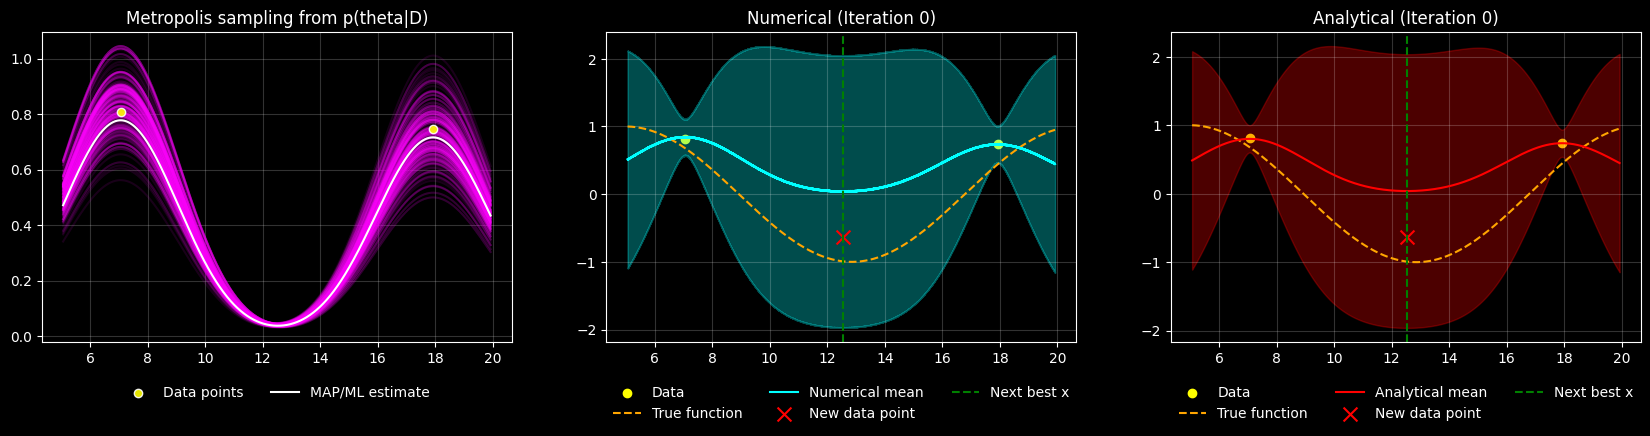


Metropolis acceptance rate: 0.43


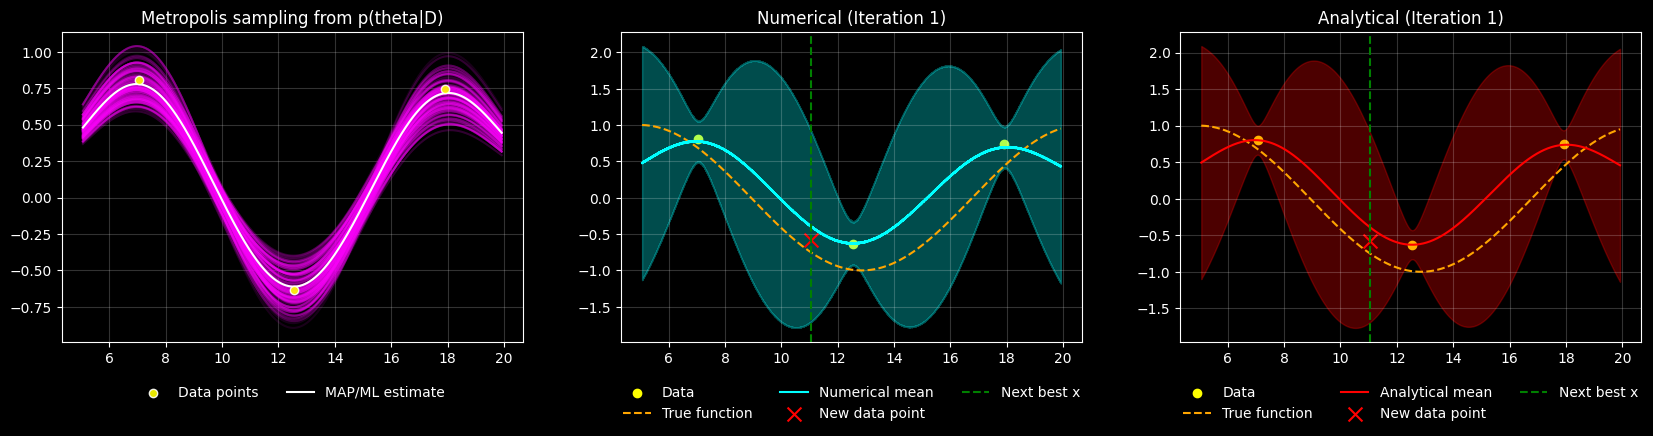


Metropolis acceptance rate: 0.38


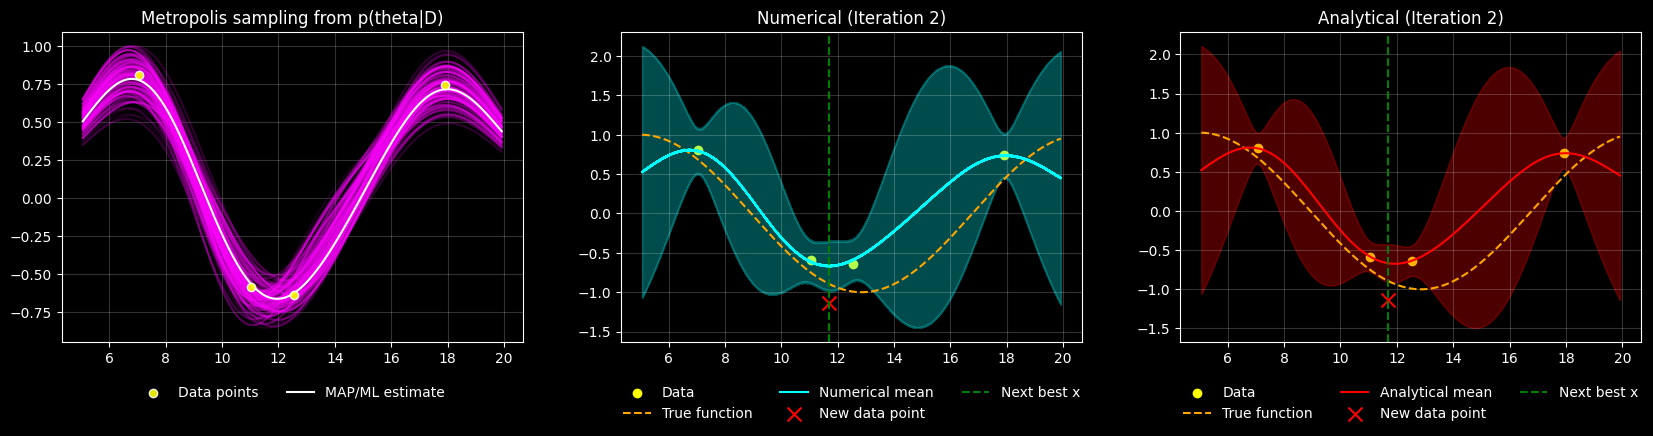


Metropolis acceptance rate: 0.31


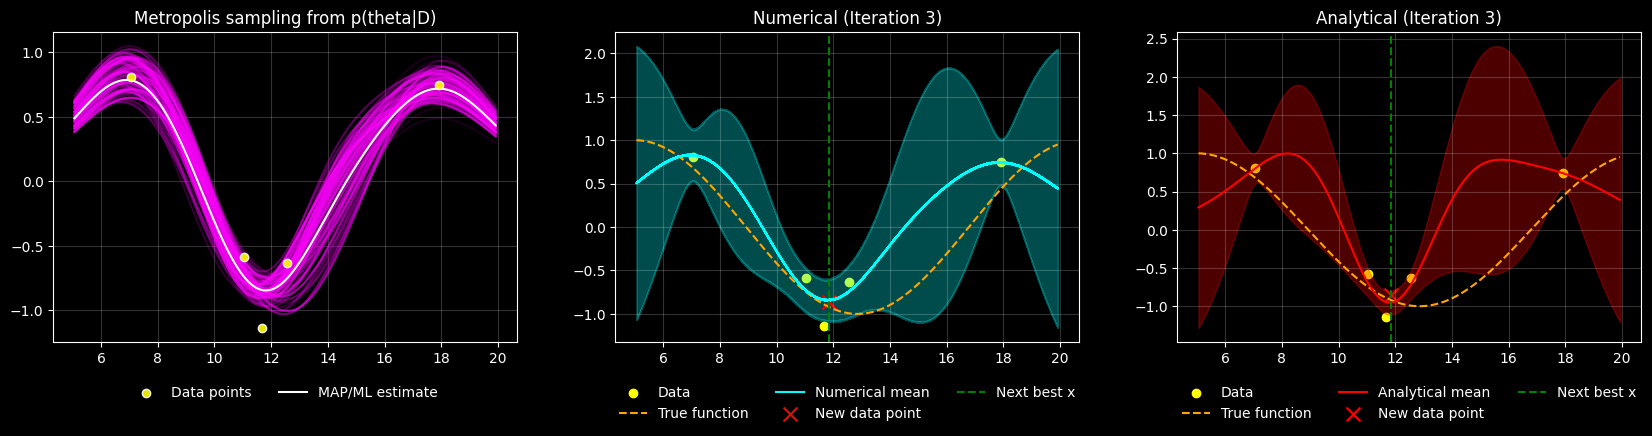


Metropolis acceptance rate: 0.30


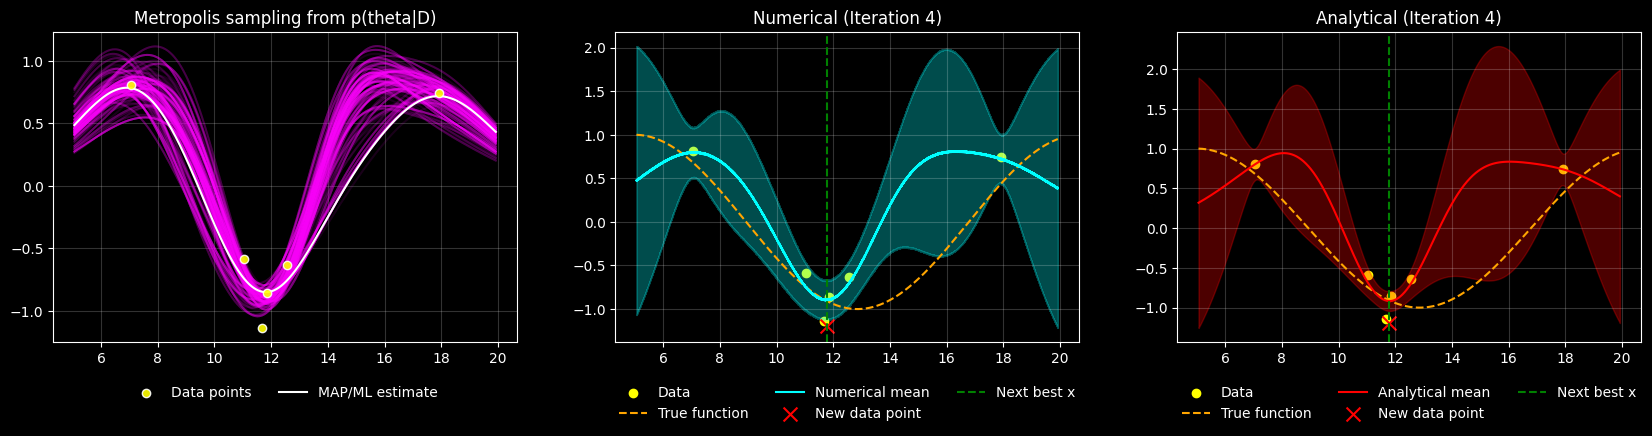


Metropolis acceptance rate: 0.21


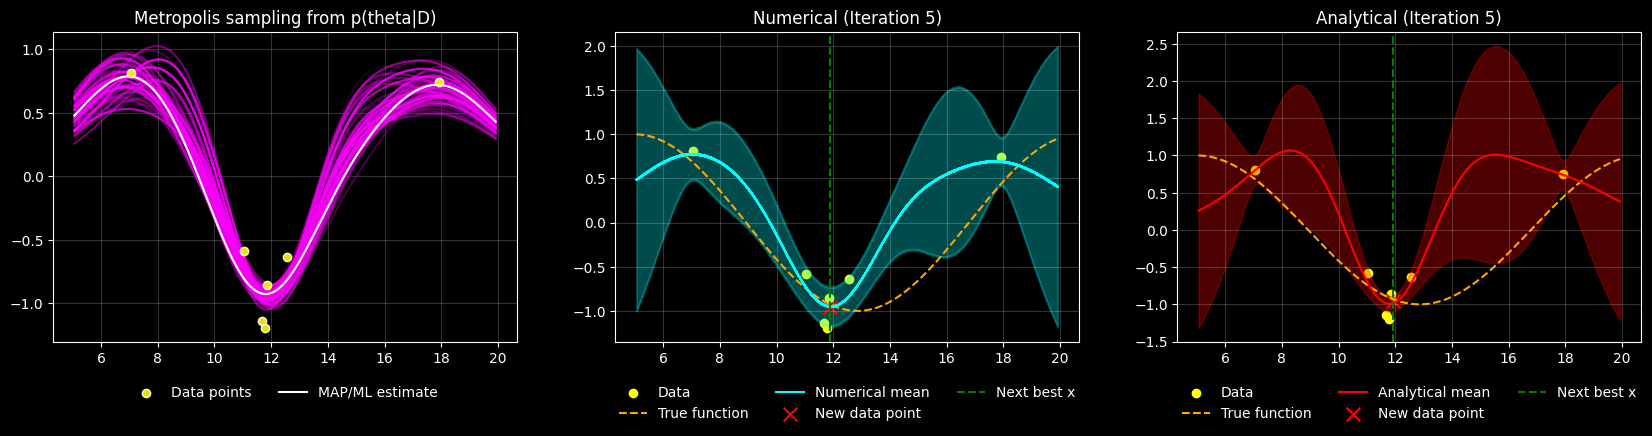


Metropolis acceptance rate: 0.22


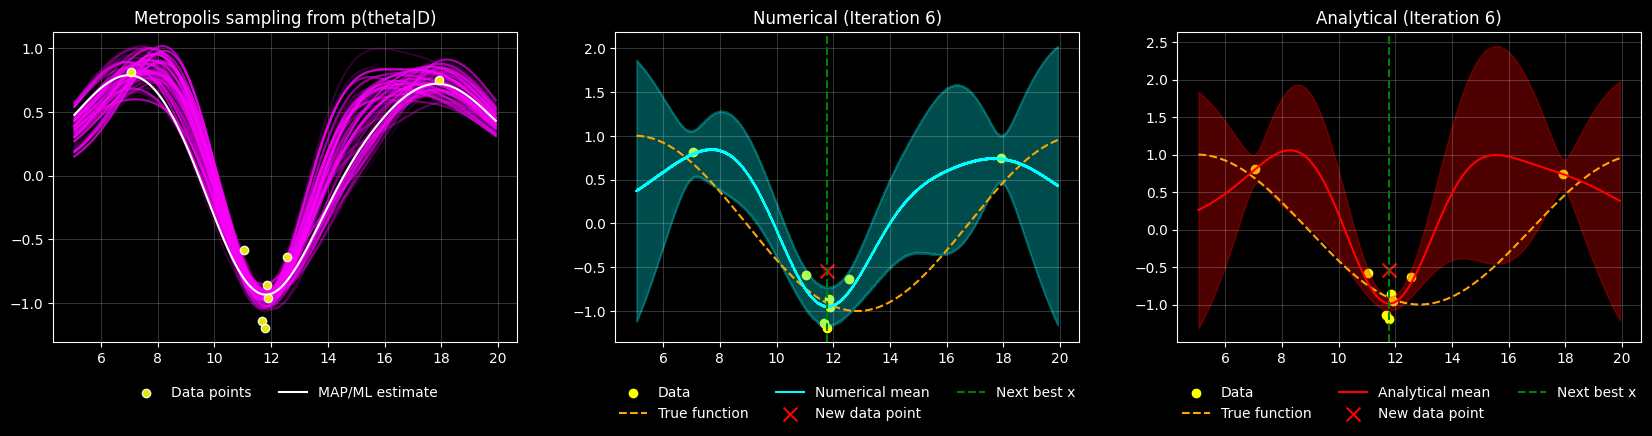


Metropolis acceptance rate: 0.25


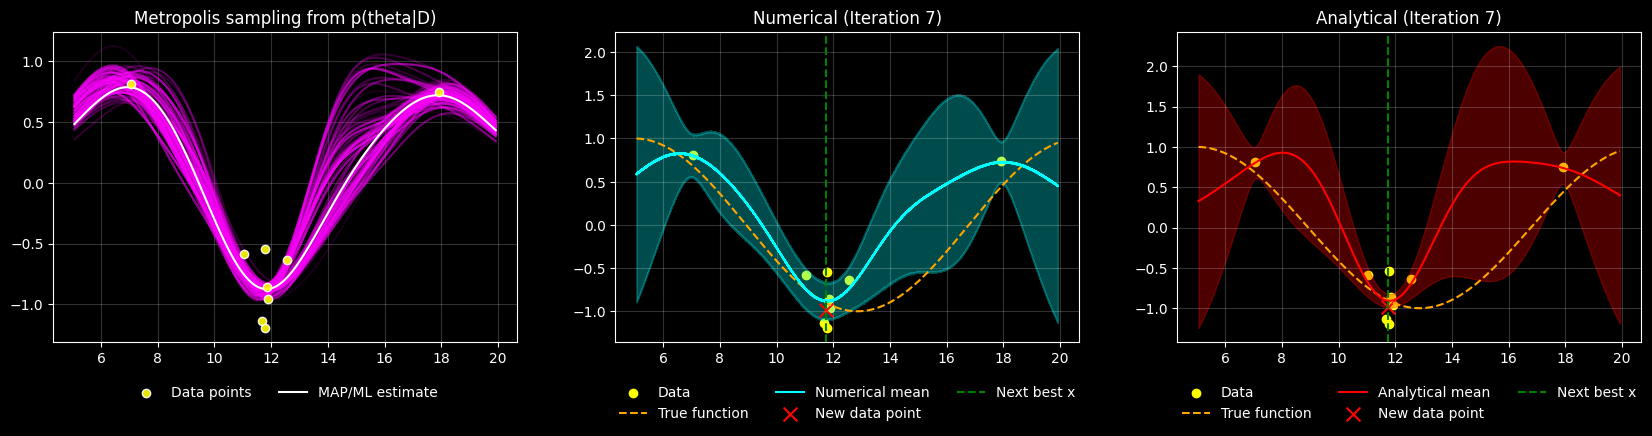


Metropolis acceptance rate: 0.22


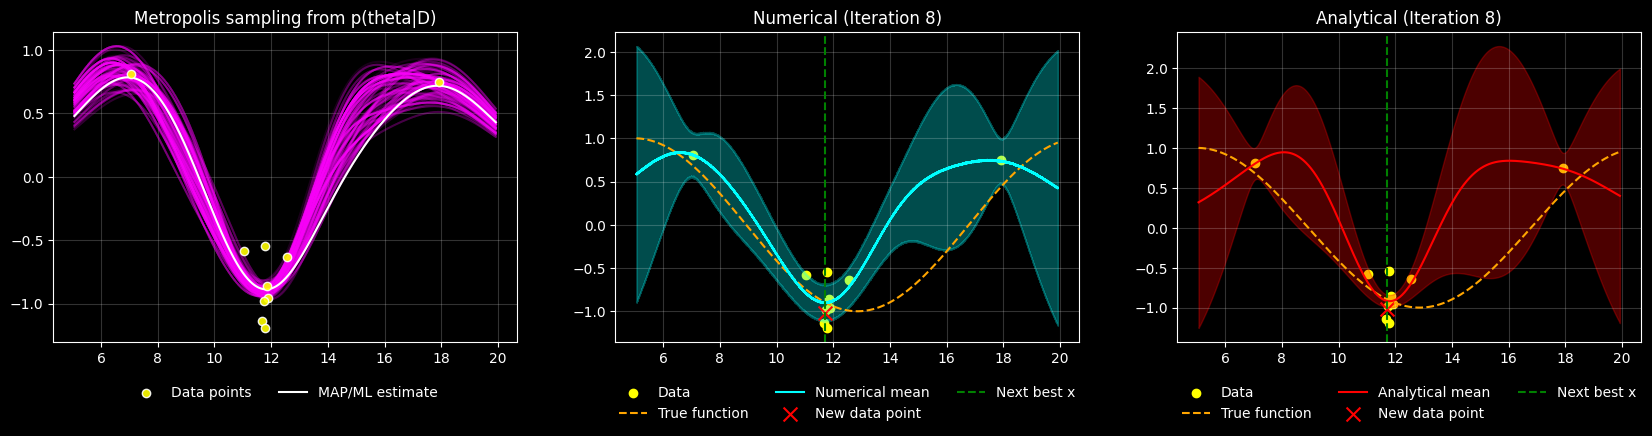


Metropolis acceptance rate: 0.21


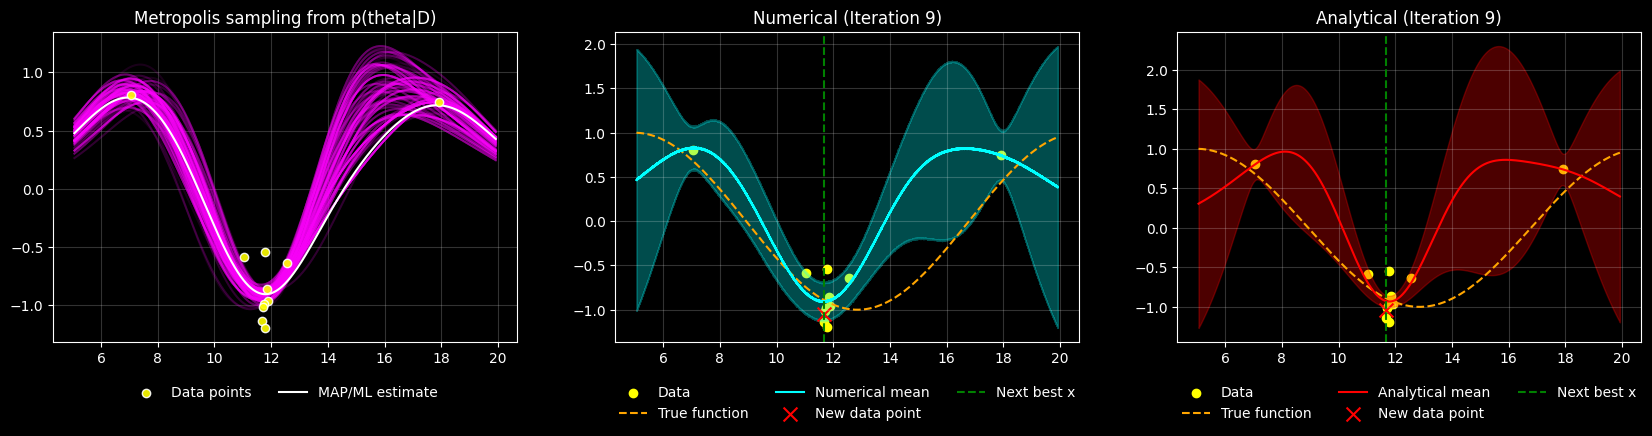

In [3]:
kernel_reg = BayesianKernelRegression(num_points=2, num_x_test=100**2, debug=False, random_seed=42, lcb_k=1.0)

# Bayesian optimization
kernel_reg.main_bo_lcb(max_iterations=10, convergence_threshold=None)